# Import Library

In [ ]:
# file directory manager
import os
import shutil
import pickle
from google.colab import files 

# data process
import numpy as np
import pandas as pd

# tensorflow utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# image processing
from PIL import Image
import cv2

# model evaluating
from sklearn.metrics import confusion_matrix, classification_report

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# mount drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

In [ ]:
data_path = "/content/potato"
shutil.rmtree(data_path, ignore_errors=True)
# extract zip file
! unzip "/content/drive/Shareddrives/Tanamin Team/Machine Learning/datasets/potato/potato.zip" -d .

# EDA

In [ ]:
diseases = os.listdir(data_path)
diseases

['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']

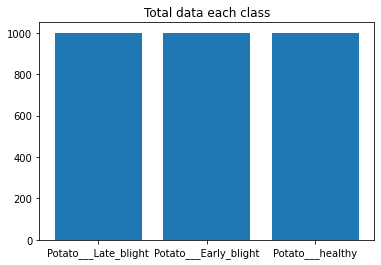

In [ ]:
dict_diseases = {}

for disease in diseases:
  list_file = os.listdir(os.path.join(data_path, disease))
  dict_diseases[disease] = len(list_file)

plt.figure(figsize=(6,4))
plt.bar(x=dict_diseases.keys(), height=dict_diseases.values())
plt.title("Total data each class")
plt.show()

show example images


Potato___Late_blight


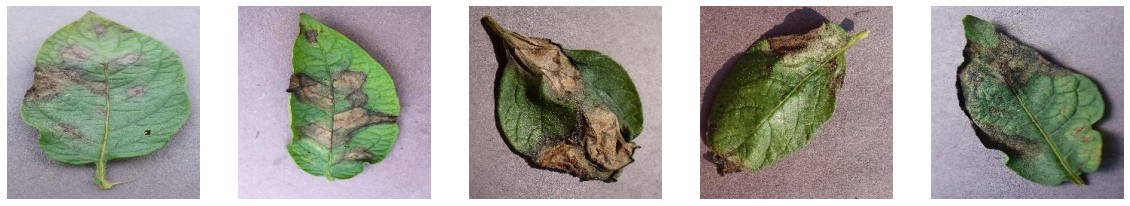


Potato___Early_blight


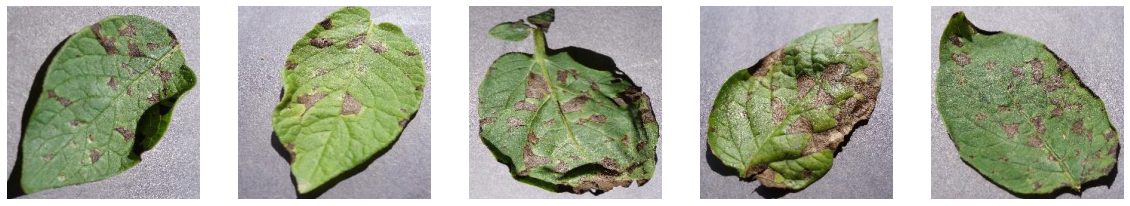


Potato___healthy


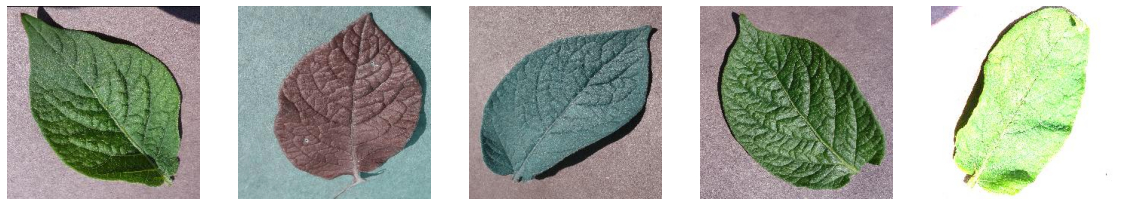

In [ ]:
for item in diseases:
  print("")
  print(item)
  class_dir = os.path.join(data_path, item)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

# Choosing Labels

choosing the label
- Early Blight : valid (bercak kering)
- Lately Blight : valid (busuk daun/hawar daun)
- Healthy : valid (sehat)


ref : 
- https://www.corteva.id/berita/Hama-dan-Penyakit-pada-Tanaman-Kentang.html

In [ ]:
ori_labels = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
# delete label
delete_label = []

if len(delete_label) > 0:
  for label in delete_label:
    shutil.rmtree(os.path.join('data/mixed/finaldata', label), ignore_errors=True)

# Modelling

## Preparing ImageDataGenerator

In [ ]:
finaldata_dir = data_path
img_dim = 224
img_shape = (224, 224, 3)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2 
)

train_generator = datagen.flow_from_directory(
    finaldata_dir,
    target_size =(img_dim, img_dim),
    batch_size = 100,
    class_mode = 'categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    finaldata_dir,
    target_size = (img_dim,img_dim),
    batch_size = 25,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [ ]:
labels = []
for label in train_generator.class_indices:
  labels.append(label)
num_labels = len(labels)

print("Labels: {}".format(labels))
print("Num labels: {}".format(num_labels))

Labels: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Num labels: 3


## Init Method

In [ ]:
# define my callbacks include (EarlyStopping, ModelCheckpoint)
def my_callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

  return [mc]

In [ ]:
# define method for showing plot learning curves
def plot_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(6, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
# define confusion matrix method
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(labels, rotation=45)
  ax.yaxis.set_ticklabels(labels, rotation=45)

  plt.show()

In [ ]:
# define classification report method
def class_report(y_test, y_pred):
  print("Labels: ",train_generator.class_indices)
  print()
  print(classification_report(y_test, y_pred))

In [ ]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# save model history method
def saved_model_history(modelname, history):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "potato_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "potato_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(labels))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [ ]:
# save all model with simplify function
def save_all_model(modelname, model, history):
  # save model
  saved_model(modelname, model)

  # save history as dict
  saved_model_history(modelname, history)

  # save best model
  best_model = tf.keras.models.load_model('best_{}.h5'.format(modelname))
  best_modelname = "BestMC_{}".format(modelname)
  saved_model(best_modelname, best_model)
  # clear best model h5 format
  os.remove('best_{}.h5'.format(modelname))

  # save tflite best model
  tflite_model_convert(best_modelname, modelname)

  %cp -av "/content/saved_model_history" "/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models"
  %cp -av "/content/saved_model" "/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models"
  %cp -av "/content/tflite_model" "/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models"

## Model 1

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=img_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')  
])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 26, 26, 64)      

In [ ]:
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
# fitting model
history1 = model1.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_OwnModel.h5"),
)

Epoch 1/25
24/24 [==============================] - ETA: 0s - loss: 1.0819 - accuracy: 0.4871
Epoch 1: val_accuracy improved from -inf to 0.66833, saving model to best_OwnModel.h5
24/24 [==============================] - 184s 8s/step - loss: 1.0819 - accuracy: 0.4871 - val_loss: 0.7106 - val_accuracy: 0.6683
Epoch 2/25
24/24 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.7667
Epoch 2: val_accuracy improved from 0.66833 to 0.83167, saving model to best_OwnModel.h5
24/24 [==============================] - 172s 7s/step - loss: 0.5342 - accuracy: 0.7667 - val_loss: 0.4883 - val_accuracy: 0.8317
Epoch 3/25
24/24 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8617
Epoch 3: val_accuracy improved from 0.83167 to 0.86500, saving model to best_OwnModel.h5
24/24 [==============================] - 171s 7s/step - loss: 0.3775 - accuracy: 0.8617 - val_loss: 0.3190 - val_accuracy: 0.8650
Epoch 4/25
24/24 [==============================] - ETA: 0s - lo

In [ ]:
score_train = model1.evaluate(train_generator)
score_valid = model1.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

24/24 [==============================] - 2s 76ms/step - loss: 0.1144 - accuracy: 0.9633
Accuracy (train):  1.0
Accuracy (test): 0.9633333086967468
Loss (train):  0.00021198074682615697
Loss (test): 0.11439100652933121


### Plot Learning Curves

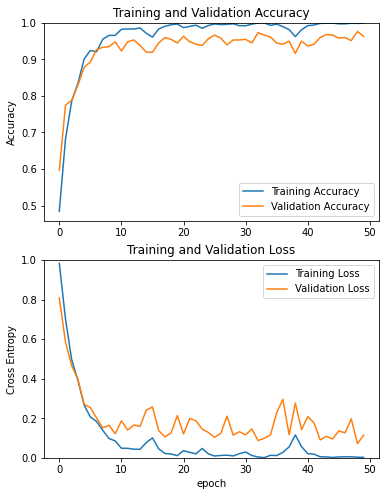

In [ ]:
plot_learning_curves(history1)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


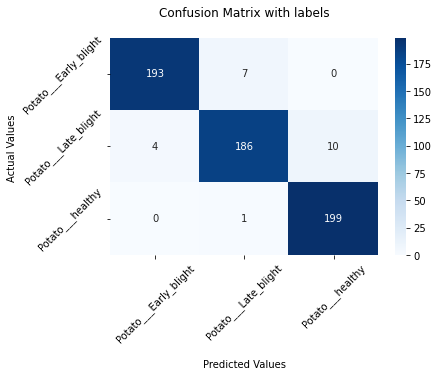

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       200
           1       0.96      0.93      0.94       200
           2       0.95      0.99      0.97       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



### Save Model

In [ ]:
# save all model
modelname = "OwnModel"
save_all_model(modelname, model1, history1)

## Model 2

In [ ]:
from tensorflow.keras.applications import ResNet50    # underfit
from tensorflow.keras.applications import ResNet152V2 # overfit

model2 = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=img_shape)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')  
])

model2.layers[0].trainable = False

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                      

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_ResNet152V2.h5")
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.6792
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to best_ResNet152V2.h5
24/24 [==============================] - 23s 620ms/step - loss: 0.7365 - accuracy: 0.6792 - val_loss: 0.3832 - val_accuracy: 0.8667
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8988
Epoch 2: val_accuracy improved from 0.86667 to 0.89667, saving model to best_ResNet152V2.h5
24/24 [==============================] - 13s 522ms/step - loss: 0.2697 - accuracy: 0.8988 - val_loss: 0.2826 - val_accuracy: 0.8967
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9262
Epoch 3: val_accuracy improved from 0.89667 to 0.91000, saving model to best_ResNet152V2.h5
24/24 [==============================] - 13s 523ms/step - loss: 0.2100 - accuracy: 0.9262 - val_loss: 0.2446 - val_accuracy: 0.9100
Epoch 4/50
24/24 [==============================]

In [ ]:
score_train = model2.evaluate(train_generator)
score_valid = model2.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

24/24 [==============================] - 3s 111ms/step - loss: 0.1241 - accuracy: 0.9583
Accuracy (train):  1.0
Accuracy (test): 0.9583333134651184
Loss (train):  0.0056985244154930115
Loss (test): 0.12407252192497253


### Plot Learning Curves

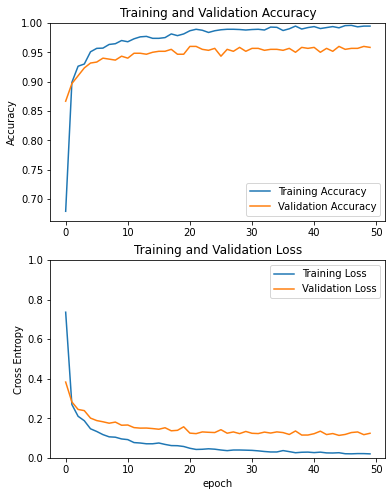

In [ ]:
plot_learning_curves(history2)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


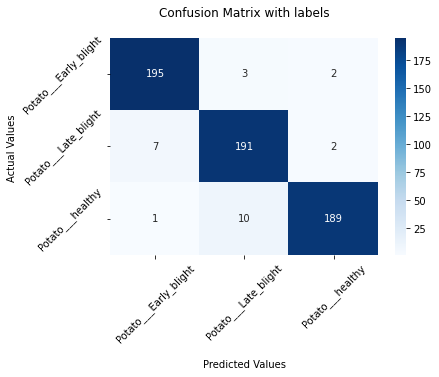

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       200
           1       0.94      0.95      0.95       200
           2       0.98      0.94      0.96       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



### Save Model

In [ ]:
# save all model
modelname = "ResNet152V2"
save_all_model(modelname, model2, history2)

## Model 3

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

model3 = tf.keras.Sequential([
    DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model3.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 3)                 15

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_DenseNet121.h5"),
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7604
Epoch 1: val_accuracy improved from -inf to 0.59500, saving model to best_DenseNet121.h5
24/24 [==============================] - 39s 726ms/step - loss: 0.5943 - accuracy: 0.7604 - val_loss: 0.9713 - val_accuracy: 0.5950
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9929
Epoch 2: val_accuracy improved from 0.59500 to 0.88667, saving model to best_DenseNet121.h5
24/24 [==============================] - 16s 644ms/step - loss: 0.0384 - accuracy: 0.9929 - val_loss: 0.2793 - val_accuracy: 0.8867
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9996
Epoch 3: val_accuracy improved from 0.88667 to 0.96667, saving model to best_DenseNet121.h5
24/24 [==============================] - 16s 640ms/step - loss: 0.0102 - accuracy: 0.9996 - val_loss: 0.1031 - val_accuracy: 0.9667
Epoch 4/50
24/24 [==============================]

In [ ]:
score_train = model3.evaluate(train_generator)
score_valid = model3.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

24/24 [==============================] - 2s 81ms/step - loss: 0.0105 - accuracy: 0.9967
Accuracy (train):  1.0
Accuracy (test): 0.996666669845581
Loss (train):  5.3665804443880916e-05
Loss (test): 0.010500174947082996


### Plot Learning Curves

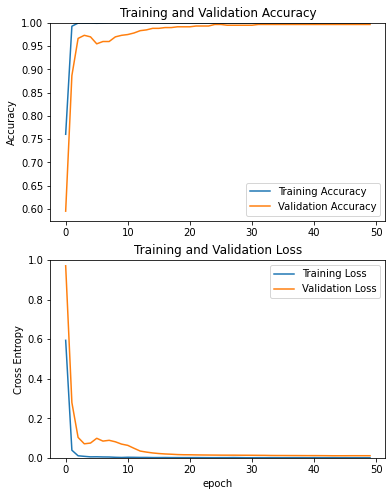

In [ ]:
plot_learning_curves(history3)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model3.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


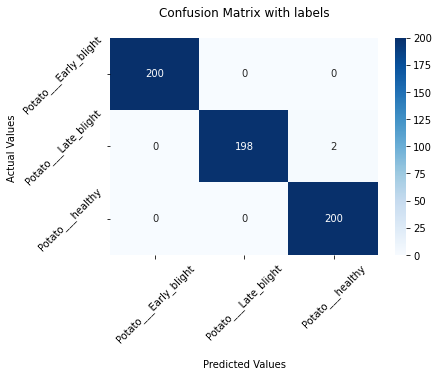

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      0.99      0.99       200
           2       0.99      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



### Save Model

In [ ]:
# save all model
modelname = "DenseNet121"
save_all_model(modelname, model3, history3)


Already saved a model, replace to new model

Export path:  saved_model/DenseNet121
['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']
Export path:  saved_model/BestMC_DenseNet121
['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']
Export path:  tflite_model/DenseNet121
['potato_densenet121.tflite', 'potato_densenet121.txt']
'/content/saved_model_history/DenseNet121' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/DenseNet121'
'/content/saved_model/DenseNet121' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model/DenseNet121'
'/content/saved_model/DenseNet121/variables' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model/DenseNet121/variables'
'/content/saved_model/DenseNet121/variables/variables.data-00000-of-00001' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model/DenseNet121/var

## Model 4

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=img_shape,
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = True

pre_trained_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(num_labels, activation='softmax')(x) 

model4 = tf.keras.Model(pre_trained_model.input, x)

model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history4 = model4.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_InceptionV3.h5"),
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.6796
Epoch 1: val_accuracy improved from -inf to 0.69667, saving model to best_InceptionV3.h5
24/24 [==============================] - 17s 496ms/step - loss: 0.7025 - accuracy: 0.6796 - val_loss: 0.7727 - val_accuracy: 0.6967
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9621
Epoch 2: val_accuracy improved from 0.69667 to 0.83500, saving model to best_InceptionV3.h5
24/24 [==============================] - 12s 495ms/step - loss: 0.1110 - accuracy: 0.9621 - val_loss: 0.4500 - val_accuracy: 0.8350
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9917
Epoch 3: val_accuracy improved from 0.83500 to 0.88500, saving model to best_InceptionV3.h5
24/24 [==============================] - 11s 453ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.2921 - val_accuracy: 0.8850
Epoch 4/50
24/24 [==============================]

In [ ]:
score_train = model4.evaluate(train_generator)
score_valid = model4.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

24/24 [==============================] - 2s 80ms/step - loss: 0.0047 - accuracy: 0.9983
Accuracy (train):  1.0
Accuracy (test): 0.9983333349227905
Loss (train):  7.764386282360647e-06
Loss (test): 0.004656630102545023


### Plot Learning Curves

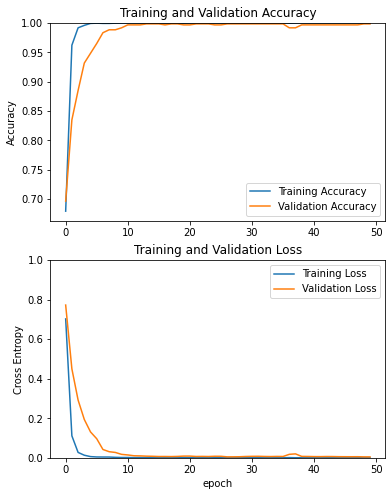

In [ ]:
plot_learning_curves(history4)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model4.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


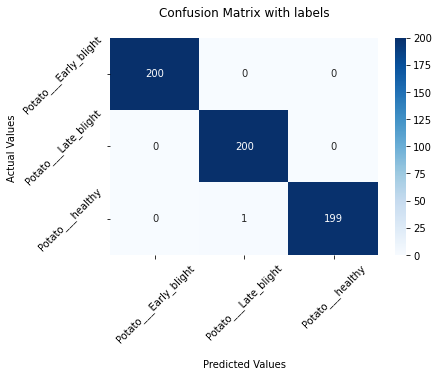

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       1.00      0.99      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



### Save Model

In [ ]:
# save model
modelname = "InceptionV3"
save_all_model(modelname, model4, history4)

Export path:  saved_model/InceptionV3
['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']
Export path:  saved_model/BestMC_InceptionV3
['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']
Export path:  tflite_model/InceptionV3
['potato_inceptionv3.tflite', 'potato_inceptionv3.txt']
'/content/saved_model_history/DenseNet121' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/DenseNet121'
'/content/saved_model_history/InceptionV3' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/InceptionV3'
'/content/saved_model/DenseNet121/variables/variables.data-00000-of-00001' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model/DenseNet121/variables/variables.data-00000-of-00001'
'/content/saved_model/DenseNet121/variables/variables.index' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model

## Model 5

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

model5 = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=img_shape),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')  
])

model5.layers[0].trainable = False

model5.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                         

In [ ]:
model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history5 = model5.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_MobileNetV2.h5"),
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.5697 - accuracy: 0.7954
Epoch 1: val_accuracy improved from -inf to 0.93167, saving model to best_MobileNetV2.h5
24/24 [==============================] - 15s 443ms/step - loss: 1.5697 - accuracy: 0.7954 - val_loss: 1.0521 - val_accuracy: 0.9317
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.9617
Epoch 2: val_accuracy improved from 0.93167 to 0.95333, saving model to best_MobileNetV2.h5
24/24 [==============================] - 9s 385ms/step - loss: 0.8832 - accuracy: 0.9617 - val_loss: 0.8098 - val_accuracy: 0.9533
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.9767
Epoch 3: val_accuracy improved from 0.95333 to 0.95667, saving model to best_MobileNetV2.h5
24/24 [==============================] - 9s 385ms/step - loss: 0.6966 - accuracy: 0.9767 - val_loss: 0.7059 - val_accuracy: 0.9567
Epoch 4/50
24/24 [==============================] -

In [ ]:
score_train = model5.evaluate(train_generator)
score_valid = model5.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

24/24 [==============================] - 2s 82ms/step - loss: 0.1493 - accuracy: 0.9700
Accuracy (train):  0.9991666674613953
Accuracy (test): 0.9700000286102295
Loss (train):  0.048848796635866165
Loss (test): 0.14931631088256836


### Plot Learning Curves

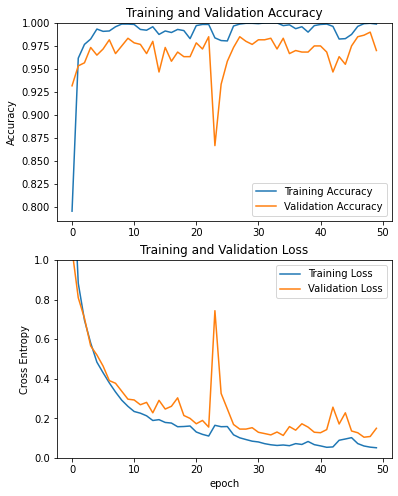

In [ ]:
plot_learning_curves(history5)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model5.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


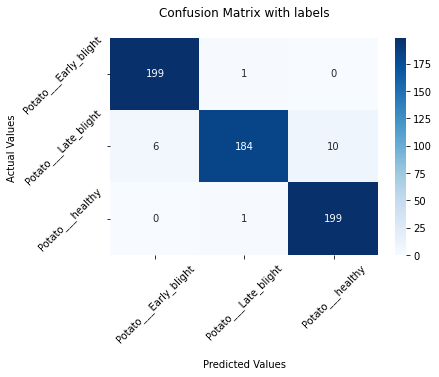

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       200
           1       0.99      0.92      0.95       200
           2       0.95      0.99      0.97       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



### Save Model

In [ ]:
# save model
modelname = "MobileNetV2"
save_all_model(modelname, model5, history5)

Export path:  saved_model/MobileNetV2
['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']


Export path:  saved_model/BestMC_MobileNetV2
['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']
Export path:  tflite_model/MobileNetV2
['potato_mobilenetv2.tflite', 'potato_mobilenetv2.txt']
'/content/saved_model_history/DenseNet121' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/DenseNet121'
'/content/saved_model_history/InceptionV3' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/InceptionV3'
'/content/saved_model_history/MobileNetV2' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/MobileNetV2'
'/content/saved_model/DenseNet121/variables/variables.data-00000-of-00001' -> '/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model/DenseNet121/variables/variables.data-00000-of-00001'
'/content/saved_model/DenseNet121/variables/variables.index' -> '/content/drive/Shareddrives/Tana

# Load All Model 

In [ ]:
# delete folder
shutil.rmtree('saved_model', ignore_errors=True)
shutil.rmtree('saved_model_history', ignore_errors=True)
shutil.rmtree('tflite_model', ignore_errors=True)

In [ ]:
# copy folder
%cp -av "/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history" "/content"
%cp -av "/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model" "/content"
%cp -av "/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/tflite_model" "/content"

'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history' -> '/content/saved_model_history'
'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/DenseNet121' -> '/content/saved_model_history/DenseNet121'
'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/InceptionV3' -> '/content/saved_model_history/InceptionV3'
'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/MobileNetV2' -> '/content/saved_model_history/MobileNetV2'
'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/ResNet152V2' -> '/content/saved_model_history/ResNet152V2'
'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_models/saved_model_history/OwnModel' -> '/content/saved_model_history/OwnModel'
'/content/drive/Shareddrives/Tanamin Team/Machine Learning/models/potato_mod

# Choosing The Model

## Plot History All Model

In [ ]:
list_modelnames = ["OwnModel", "ResNet152V2", "DenseNet121", "InceptionV3", "MobileNetV2"]
dict_histories = {}
saved_model_his = "saved_model_history"

# load model into new variable
for modelname in list_modelnames:
  with open(os.path.join(saved_model_his, modelname), 'rb') as file_pi:
    dict_histories[modelname] = pickle.load(file_pi)

dict_histories.keys()

dict_keys(['OwnModel', 'ResNet152V2', 'DenseNet121', 'InceptionV3', 'MobileNetV2'])

comparing accuracy history all model

In [ ]:
dict_acc = {}
dict_val_acc = {}
dict_loss = {}
dict_val_loss = {}

for modelname in list_modelnames:
  dict_acc[modelname] = dict_histories[modelname]['accuracy']
  dict_val_acc[modelname] = dict_histories[modelname]['val_accuracy']
  dict_loss[modelname] = dict_histories[modelname]['loss']
  dict_val_loss[modelname] = dict_histories[modelname]['val_loss']

label_plot = ['Own Model','ResNet152V2','DenseNet121','InceptionV3','MobileNetV2']
marker_plot = ['o','x','v','^','d']

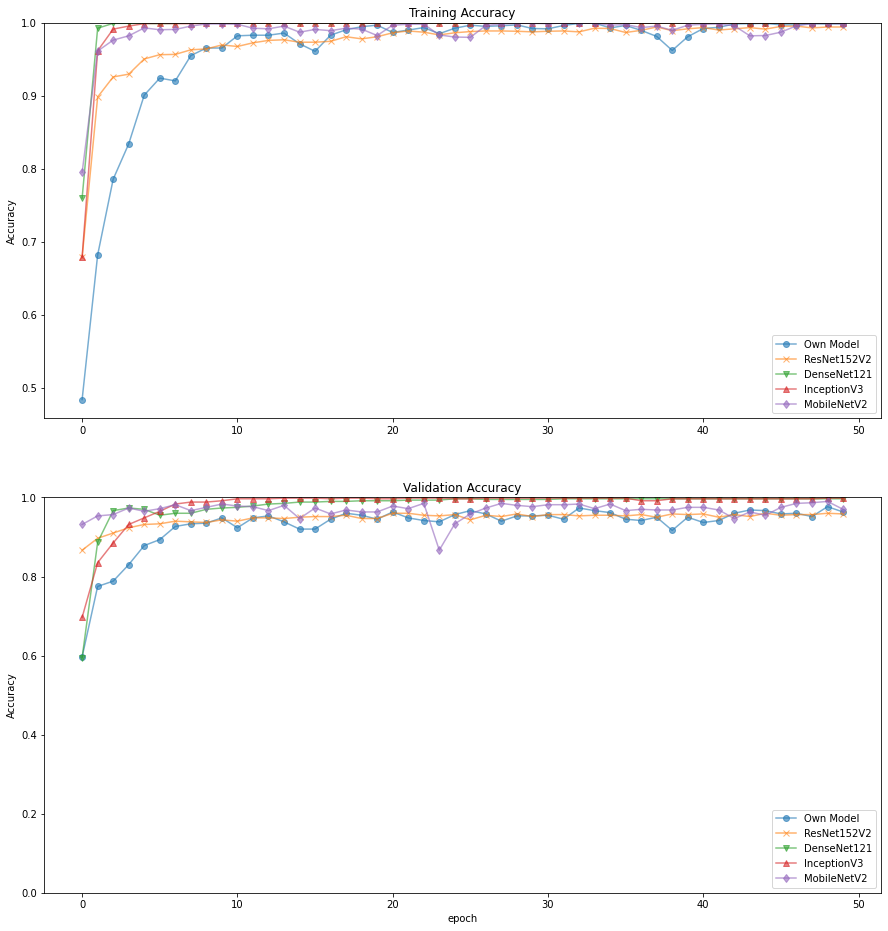

In [ ]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)
for i in range(len(list_modelnames)):
  plt.plot(dict_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
for i in range(len(list_modelnames)):
  plt.plot(dict_val_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('acc_all_model.png')

plt.show()

comparing loss history all model

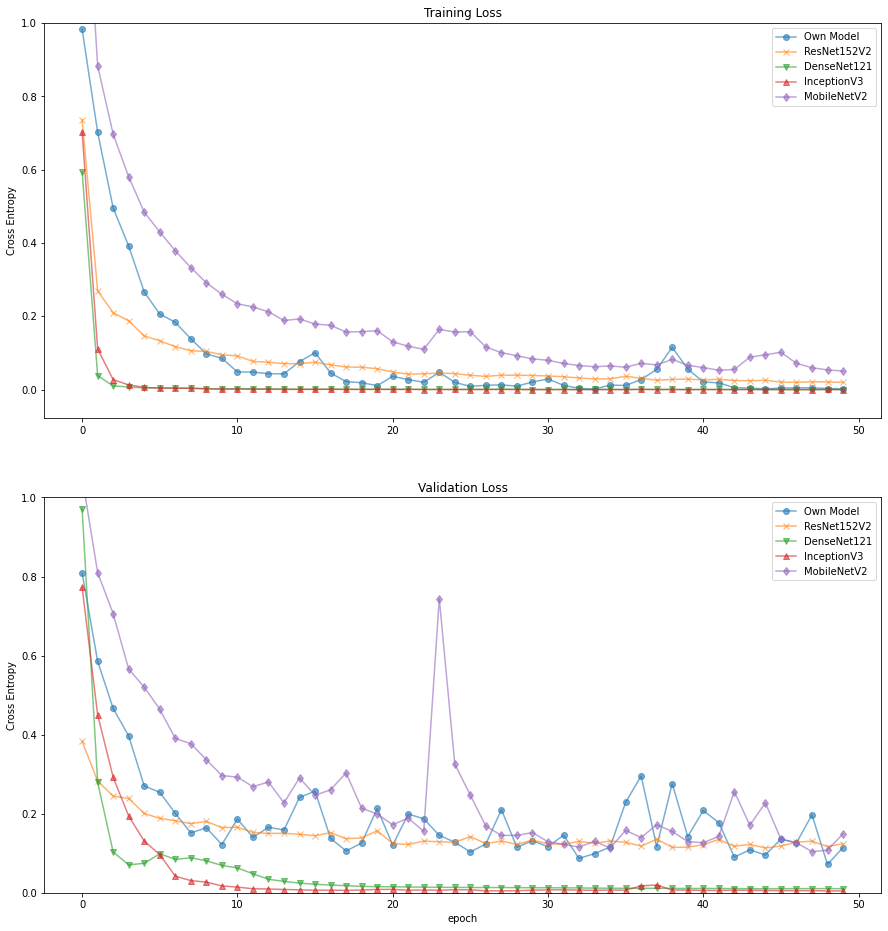

In [ ]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)

for i in range(len(list_modelnames)):
  plt.plot(dict_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Loss')

plt.subplot(2, 1, 2)

for i in range(len(list_modelnames)):
  plt.plot(dict_val_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)
  
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Validation Loss')
plt.xlabel('epoch')

plt.savefig('loss_all_model.png')

plt.show()

## Plot Performance All Best Model

In [ ]:
list_modelnames = ["OwnModel", "ResNet152V2", "DenseNet121", "InceptionV3", "MobileNetV2"]
dict_models = {}

# load model into new variable
for modelname in list_modelnames:
  dict_models[modelname] = tf.keras.models.load_model('saved_model/BestMC_{}'.format(modelname))

dict_models.keys()

dict_keys(['OwnModel', 'ResNet152V2', 'DenseNet121', 'InceptionV3', 'MobileNetV2'])

In [ ]:
# evaluate all model
dict_score_train = {}
dict_score_valid = {}

for modelname in list_modelnames:
  dict_score_train[modelname] = dict_models[modelname].evaluate(train_generator)
  dict_score_valid[modelname] = dict_models[modelname].evaluate(validation_generator)

24/24 [==============================] - 2s 78ms/step - loss: 0.1077 - accuracy: 0.9900


In [ ]:
# prepare data before plot
df1 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[1] for eval in dict_score_train.values()],
    'Valid': [eval[1] for eval in dict_score_valid.values()],
})

df2 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[0] for eval in dict_score_train.values()],
    'Valid': [eval[0] for eval in dict_score_valid.values()],
})

tidy1 = df1.melt(id_vars='Model').rename(columns=str.title)

tidy2 = df2.melt(id_vars='Model').rename(columns=str.title)

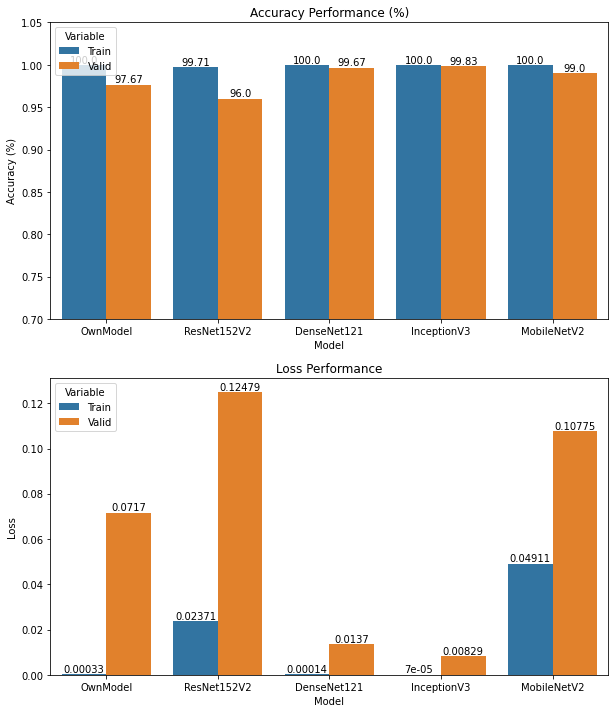

In [ ]:
# plot comparison all models evaluate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# first plot
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy1, ax=ax1)
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim([0.7 ,1.05])
ax1.set_title('Accuracy Performance (%)')

for p, data in zip(ax1.patches, tidy1['Value']):
    ax1.annotate(round(data*100, 2), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

# second plot
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy2, ax=ax2)
ax2.set_ylabel('Loss')
ax2.set_title('Loss Performance')

for p, data in zip(ax2.patches, tidy2['Value']):
    ax2.annotate(round(data, 5), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.savefig('evaluate_all_model.png')
plt.show()

## Conclusion

**DenseNet121 Model** has high accuracy and lower loss also the model is not too complex, it will be used for Potato Leaf Disease Prediction feature

# Predict Model with User Image Input

In [ ]:
best_model = tf.keras.models.load_model('saved_model/BestMC_DenseNet121')

Saving _738_3883655.png to _738_3883655.png

Predict:
Early Blight

Probablity:
Early Blight : 99.89%
Late Blight : 0.09%
Healthy : 0.02%


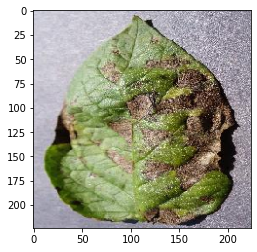

In [ ]:
# get user image input
labels = ['Early Blight', 'Late Blight', 'Healthy']

uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  images /= 255

  classes = best_model.predict(images, batch_size=32)
  predicted_class_indices=np.argmax(classes)


print("\nPredict:")
if predicted_class_indices == 0:
  print('Early Blight')
elif predicted_class_indices == 1:
  print('Late Blight')
elif predicted_class_indices == 2:
  print('Healthy')

print("\nProbablity:")
for idx, val in enumerate(labels):
  print("{} : {:.2f}%".format(val, classes[0][idx] * 100))